# Cnovection--diffusion equation solved using stabilised finite element methods

`dolfinx` implementation of method described in the paper


Our aim is to solve the continuation problem for the Cnovection--diffusion equation

$$
  -\nabla^2 u(x) + \beta \cdot \nabla u(x) = f(x)   \text{ for }x \in \Omega, \\
  u(x) = q(x) \text{ for } x \in \omega
$$ 

on a spatial domain $\Omega$ with $\omega \subset \Omega$ for $u \in H^2(\Omega)$ where $k$, the wave number, $f$, the source term, and $q$, the value of the field on $\omega$, are all known.


In [1]:
from typing import Optional
import ufl
import dolfinx
from dolfinx.fem import Constant, FunctionSpace, LinearProblem
from dolfinx_helpers import (
    define_dirchlet_boundary_conditions, 
    get_matplotlib_triangulation_from_mesh,
    project_expression_on_function_space,
    plot_functions_as_heatmaps,
    plot_functions_as_surfaces
)
from dolfinx.mesh import create_unit_square, DiagonalType
from dolfinx.cpp.mesh import h
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

## Define mesh

We use $\Omega = [0, 1] \times [0, 1]$ therefore create a unit square mesh with alternating diagonal triangulation.

num_cells_per_dimension = 64
mesh = create_unit_square(
    comm=MPI.COMM_WORLD, 
    nx=num_cells_per_dimension, 
    ny=num_cells_per_dimension,
    diagonal=DiagonalType.right_left
)
fig, ax = plt.subplots(figsize=(8, 8))
ax.triplot(get_matplotlib_triangulation_from_mesh(mesh))

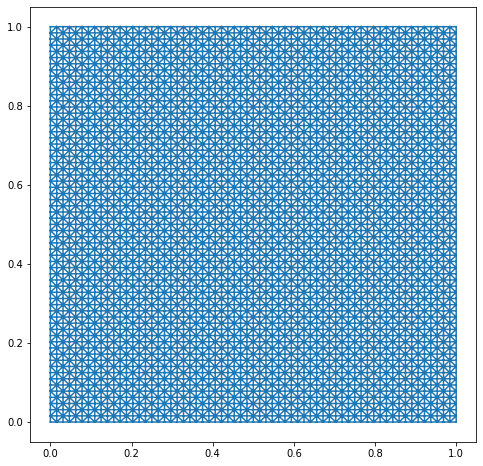

In [2]:
num_cells_per_dimension = 64
mesh = create_unit_square(
    comm=MPI.COMM_WORLD, 
    nx=num_cells_per_dimension, 
    ny=num_cells_per_dimension,
    diagonal=DiagonalType.right_left
)
fig, ax = plt.subplots(figsize=(8, 8))
ax.triplot(get_matplotlib_triangulation_from_mesh(mesh))

## Subdomain indicator

Convex case

$$ \omega = \Omega \setminus ([0.1, 0.9] \times [0.25, 1]) $$

$$ \omega = \Omega \setminus ([0., 0.875] \times [0.125, 0.875]) $$

Non-convex case

$$ \omega = (0.25, 0.75) \times (0, 0.5) $$


$$ \omega = (0.2, 0.45) \times (0.2, 0.45) $$

$$ \omega = (0, 0.125) \times (0.4, 0.6) \cup (0.875, 1) \times (0.4, 0.6) $$

In [3]:
def convex_omega_indicator_expression(x):
    return ufl.conditional(
        ufl.Not(ufl.And(ufl.And(x[0] >= 0.1, x[0] <= 0.9), ufl.And(x[1] >= 0.25, x[1] <= 1))), 1, 0
    )

def convex1_omega_indicator_expression(x):
    return ufl.conditional(
        ufl.Not(ufl.And(ufl.And(x[0] >= 0., x[0] <= 0.875), ufl.And(x[1] >= 0.125, x[1] <= 0.875))), 1, 0
    )

def non_convex_omega_indicator_expression(x):
    return ufl.conditional(
        ufl.And(ufl.And(x[0] > 0.25, x[0] < 0.75), ufl.And(x[1] > 0., x[1] < 0.5)), 1, 0
    )

def non1_convex_omega_indicator_expression(x):
    return ufl.conditional(
        ufl.And(ufl.And(x[0] > 0.2, x[0] < 0.45), ufl.And(x[1] > 0.2, x[1] < 0.45)), 1, 0
    )
def non2_convex_omega_indicator_expression(x):
    return ufl.conditional(
        ufl.Or(ufl.And(ufl.And(x[0] > 0., x[0] < 0.125), ufl.And(x[1] > 0.4, x[1] < 0.6)),
               ufl.And(ufl.And(x[0] > 0.875, x[0] < 1), ufl.And(x[1] > 0.4, x[1] < 0.6))), 1, 0
    )
def non3_convex_omega_indicator_expression(x):
    return ufl.conditional(ufl.And( ufl.And(ufl.And(x[0] > 0.25, x[0] < 0.75), ufl.And(x[1] > 0.4, x[1] < 0.6)),
        ufl.Or(ufl.And(ufl.And(x[0] > 0., x[0] < 0.125), ufl.And(x[1] > 0.4, x[1] < 0.6)),
               ufl.And(ufl.And(x[0] > 0.875, x[0] < 1), ufl.And(x[1] > 0.4, x[1] < 0.6)))), 1, 0
    )

omega_indicator_expression = non1_convex_omega_indicator_expression(ufl.SpatialCoordinate(mesh))

## Convection--Diffusion equation variational forms

$$ G(u, v) = \int_{\Omega} \nabla u \cdot \nabla v + \beta  \cdot \nabla u v \ \mathrm{d}x- \int_{\partial \Omega} \nabla u \cdot n v \,\mathrm{d}s $$

$$ b(v) = \int_{\Omega} f v \,\mathrm{d}x $$


In [4]:
advective_velocity = Constant(mesh, (1., 0.))
facet_normal = ufl.FacetNormal(mesh)
def convectio_diffusion_equation_bilinear_form(trial_function, test_function):
    mesh = trial_function.ufl_domain().ufl_cargo()
    return (
        ufl.dot(ufl.grad(trial_function), ufl.grad(test_function))* ufl.dx 
        + ufl.dot(advective_velocity, ufl.grad(trial_function)) * test_function* ufl.dx 
        - ufl.dot(ufl.grad(trial_function),facet_normal) * test_function* ufl.ds
    ) 

def convectio_diffusion_equation_linear_form(test_function, source_expression):
    return source_expression * test_function * ufl.dx 

## Primal stabilizer

$$ s(u, v) = \gamma(1+|\beta|h_{\max}) h_{\max} \sum_{k=1}^{n_i} \int_{\Gamma_k} \mathcal{J}(\nabla u, n) \cdot \mathcal{J}(\nabla v, n) \,\mathrm{d}S + (1+|\beta|h_{\max})  \int_\omega u \cdot v \,\mathrm{d}x $$

See [this page](https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#forms-and-integrals) for description of facet interior integral notation. $\mathcal{J}$ is the jump operator. $h_{\max}$ is the maximal distance between a pair of nodes in the same cell in the mesh for computation of stabilisation term.

In [5]:
def get_h_max(mesh):
    mesh.topology.create_connectivity(2, 0)
    triangles = mesh.topology.connectivity(2, 0).array.reshape((-1, 3))
    return h(mesh, 2, triangles).max()


def primal_stabilizer_form(trial_function, test_function,  stabilization_parameter=1e-5):
    mesh = trial_function.ufl_domain().ufl_cargo()
    stabilization_parameter = Constant(mesh, stabilization_parameter)
    h_max = Constant(mesh, get_h_max(mesh)**2)
    h_max_squared = h_max**2
    facet_normal = ufl.FacetNormal(mesh)
    return stabilization_parameter * (
        (1+h_max)*h_max * ufl.dot(
            ufl.jump(ufl.grad(trial_function), facet_normal), 
            ufl.jump(ufl.grad(test_function), facet_normal)
        ) * ufl.dS
        + (1+h_max)*omega_indicator_expression* ufl.dot(trial_function, test_function) * ufl.dx
    )

## Dual stabilizer

$$ s^*(z, w) = \int_{\Omega} \nabla z \cdot \nabla w \,\mathrm{d}x +\gamma(1+|\beta|h_{\max}) h_{\max} \sum_{k=1}^{n_i} \int_{\Gamma_k} \mathcal{J}(\nabla u, n) \cdot \mathcal{J}(\nabla v, n) \,\mathrm{d}S + + (h^{-1}_{\max}+|\beta|)  \int_{\partial \Omega} u \cdot v \,\mathrm{d}x $$

In [6]:
def dual_stabilizer_form(trial_function, test_function,stabilization_parameter=1e-5):
    h_max = Constant(mesh, get_h_max(mesh)**2)
    h_max_squared = h_max**2
    return ufl.dot(ufl.grad(trial_function), ufl.grad(test_function)) * ufl.dx +stabilization_parameter * (
        (1+h_max)*h_max * ufl.dot(
            ufl.jump(ufl.grad(trial_function), facet_normal), 
            ufl.jump(ufl.grad(test_function), facet_normal)
        ) * ufl.dS
        + (1+1/(h_max))* ufl.dot(trial_function, test_function) * ufl.ds
    )

## Exact solution

$$\bar{u}(x) = u(\boldsymbol{x}) = 30 x_0(1 - x_0) x_1 (1 - x_1) , \quad q(x) = \bar{u}(x) \text{ for } x \in \omega $$

In [7]:
def true_solution(mesh):
    x = ufl.SpatialCoordinate(mesh)
    return 30 * x[0] * (1 - x[0]) * x[1] * (1 - x[1]) 
    
solution_expression = true_solution(mesh)    

## Source term

Choose $f$ such that $\bar{u}$ is exact solution to Helmholtz equation:

$$f(x) = -\nabla^2 \bar{u}(x) + \beta \cdot \nabla \bar{u}(x)$$

In [8]:
def compute_source_given_solution(solution_expression, advective_velocity):
    advective_velocity = Constant(mesh, (1., 0.))
    return -ufl.div(ufl.grad(solution_expression)) + ufl.dot( advective_velocity, ufl.grad(solution_expression))

source_expression = compute_source_given_solution(solution_expression, advective_velocity)

## Finite element function spaces

In [9]:
primal_finite_element = ufl.FiniteElement("CG", mesh.ufl_cell(), 1)
dual_finite_element  = ufl.FiniteElement("CG", mesh.ufl_cell(), 1)
primal_function_space = FunctionSpace(mesh, primal_finite_element)
primal_dual_function_space = FunctionSpace(mesh, primal_finite_element * dual_finite_element)
primal_trial_function, dual_trial_function = ufl.TrialFunctions(primal_dual_function_space)
primal_test_function, dual_test_function = ufl.TestFunctions(primal_dual_function_space)

## Bilinear form

$$ A((u, z), (v, w)) = G(u, w) + G(z, v) + s(u, v) - s^*(z, w)  $$

In [10]:
bilinear_form = (
    convectio_diffusion_equation_bilinear_form(primal_trial_function, dual_test_function)
    + convectio_diffusion_equation_bilinear_form(dual_trial_function, primal_test_function)
    + primal_stabilizer_form(primal_trial_function, primal_test_function)
    - dual_stabilizer_form(dual_trial_function, dual_test_function)

)

## Linear form

$$ L((v, w)) = \int_{\Omega} f w\,\mathrm{d} x + \int_{\omega} q v \,\mathrm{d}x $$ 

In [11]:
linear_form = (
    source_expression * dual_test_function * ufl.dx 
    + omega_indicator_expression * solution_expression * primal_test_function * ufl.dx
)

## Boundary conditions

Homogeneous Dirichlet boundary condition on *dual* component of finite element function space

$$ z(x) = 0 \text{ for } x \in \partial\Omega $$

In [12]:
boundary_conditions = [define_dirchlet_boundary_conditions(Constant(mesh, 0.), primal_dual_function_space.sub(1))]

## Set up and solve problem

In [13]:
problem = LinearProblem(
    bilinear_form, 
    linear_form, 
    boundary_conditions, 
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
solution_primal, solution_dual = problem.solve().split()

## Visualise solution

(<Figure size 1350x360 with 6 Axes>,
 array([<AxesSubplot:title={'center':'Indicator function on $\\omega$'}, xlabel='Spatial coordinate 0', ylabel='Spatial coordinate 1'>,
        <AxesSubplot:title={'center':'Solution (exact)'}, xlabel='Spatial coordinate 0', ylabel='Spatial coordinate 1'>,
        <AxesSubplot:title={'center':'Solution (numerical)'}, xlabel='Spatial coordinate 0', ylabel='Spatial coordinate 1'>],
       dtype=object))

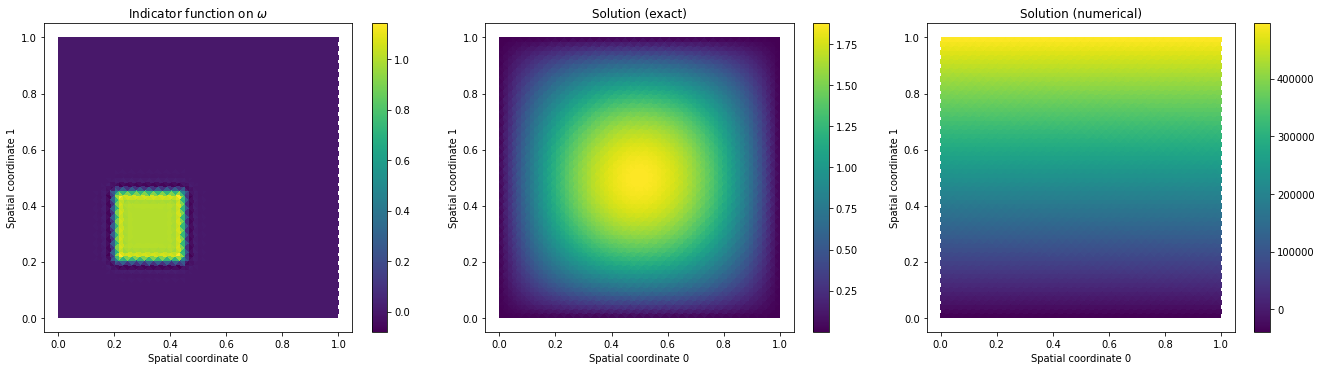

In [14]:
plot_functions_as_heatmaps(
    mesh, 
    {
        'Indicator function on $\omega$': project_expression_on_function_space(omega_indicator_expression, primal_function_space), 
        'Solution (exact)': project_expression_on_function_space(solution_expression, primal_function_space), 
        'Solution (numerical)': solution_primal,
    }
)

(<Figure size 1080x360 with 3 Axes>,
 array([<Axes3DSubplot:xlabel='Spatial coordinate 0', ylabel='Spatial coordinate 1'>,
        <Axes3DSubplot:xlabel='Spatial coordinate 0', ylabel='Spatial coordinate 1'>,
        <Axes3DSubplot:xlabel='Spatial coordinate 0', ylabel='Spatial coordinate 1'>],
       dtype=object))

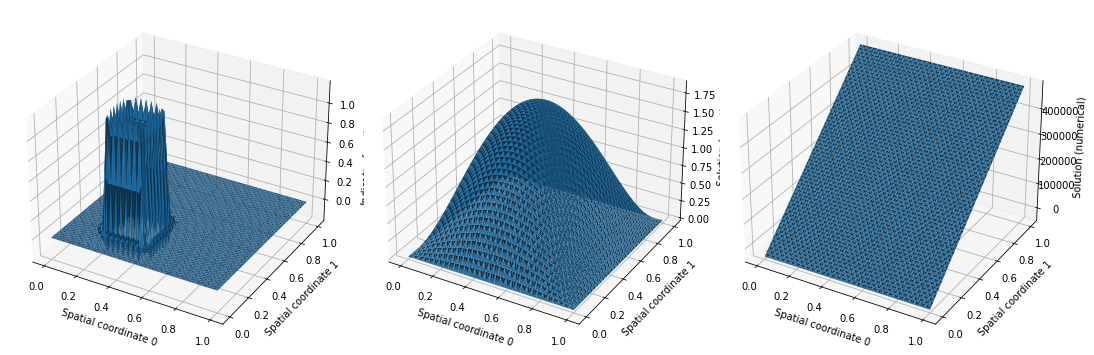

In [15]:
plot_functions_as_surfaces(
    mesh, 
    {
        'Indicator function on $\omega$': project_expression_on_function_space(omega_indicator_expression, primal_function_space), 
        'Solution (exact)': project_expression_on_function_space(solution_expression, primal_function_space), 
        'Solution (numerical)': solution_primal,
    }
)